# 1. Pre-processing

#### 1.1. Text Pre-processing

The dataset is already lowercased and lacks punctuation. We will tokenize the text and remove stopwords, as well as apply lemmatization to the tokens.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

data = pd.read_json('./data/data.jsonl', lines=True)
def pre_process_data(dataset):
    #tokenize
    dataset['text'] = dataset['text'].apply(nltk.word_tokenize)

    #remove stop words
    stop_words = set(stopwords.words('english'))
    dataset['text'] = dataset['text'].apply(lambda x: [word for word in x if word not in stop_words])

    #lemmatize
    lemmatizer = WordNetLemmatizer()
    dataset['text'] = dataset['text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

    return dataset

data = pre_process_data(data)
data.head()

C:\Users\fabio\AppData\Local\Temp\ipykernel_37480\3172380938.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fabio\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fabio\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fabio\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,text,label
0,"[feel, awful, job, get, position, succeed, hap...",0
1,"[im, alone, feel, awful]",0
2,"[ive, probably, mentioned, really, feel, proud...",1
3,"[feeling, little, low, day, back]",0
4,"[beleive, much, sensitive, people, feeling, te...",2


In [2]:
test_data = pd.read_json('./data/test.jsonl', lines=True)
train_data = pd.read_json('./data/train.jsonl', lines=True)
validation_data = pd.read_json('./data/validation.jsonl', lines=True)

test_data = pre_process_data(test_data)
train_data = pre_process_data(train_data)
validation_data = pre_process_data(validation_data)

print(test_data["text"])

0       [im, feeling, rather, rotten, im, ambitious, r...
1                      [im, updating, blog, feel, shitty]
2       [never, make, separate, ever, want, feel, like...
3       [left, bouquet, red, yellow, tulip, arm, feeli...
4                            [feeling, little, vain, one]
                              ...                        
1995    [keep, feeling, like, someone, unkind, wrong, ...
1996    [im, feeling, little, cranky, negative, doctor...
1997    [feel, useful, people, give, great, feeling, a...
1998    [im, feeling, comfortable, derby, feel, though...
1999    [feel, weird, meet, w, people, text, like, don...
Name: text, Length: 2000, dtype: object


# 2. Vectorization
(secção possívelmente temporária, mas queria experimentar as cenas de tf_idf depois do pré-processamento) -- matos
não acho que convenha ser temporaria, dado que efetivamente melhora os resultados ihihihi, e é uma prática comum e recomendada pelo que estivemos a ver -- ines


### TF-IDF

#### Hypertunning for tf-idf

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidfVectorizer(data, train_data, validation_data, test_data):
    vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features=40000)
    # good idea to use two-grams??
    # print(X.shape)

    x_train = vectorizer.fit_transform(train_data['text'].apply(lambda x: ' '.join(x)))

    x_val = vectorizer.transform(validation_data['text'].apply(lambda x: ' '.join(x)))
    x_test = vectorizer.transform(test_data['text'].apply(lambda x: ' '.join(x)))

    y_train = train_data['label']
    y_val = validation_data['label']
    y_test = test_data['label']
    
    # print(vectorizer.get_feature_names_out())

    return x_train, x_val, x_test, y_train, y_val, y_test



### BOW model
Count vectorizer which is an implementation of the BOW model.

The disadvantage of the BOW model is it does not consider the sequence of words, and as language does involve sequence and context, sometimes the BOW model might not be a good fit for the best-case scenario.

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

def countVectorizer(data, train_data, validation_data, test_data):
    # Initialize CountVectorizer
    vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,2), max_features=40000)

    x_train= vectorizer.fit_transform(train_data['text'].apply(lambda x: ' '.join(x)))

    x_val = vectorizer.transform(validation_data['text'].apply(lambda x: ' '.join(x)))
    x_test = vectorizer.transform(test_data['text'].apply(lambda x: ' '.join(x)))

    y_train = train_data['label']
    y_val = validation_data['label']
    y_test = test_data['label']

    return x_train, x_val, x_test, y_train, y_val, y_test



### Doc 2 Vec

#### Document 2 Vector training

In [8]:
# from gensim.models.doc2vec import Doc2Vec, TaggedDocument
# from sklearn import utils

# def train_doc2vec(train_data):
#     max_epochs = 100
#     vec_size = 20
#     alpha = 0.025

#     tagged_data = [TaggedDocument(words=doc, tags=[str(label)]) for doc, label in zip(train_data['text'], train_data['label'])]

#     model = Doc2Vec(vector_size=vec_size,
#                     alpha=alpha,
#                     min_alpha=0.00025,
#                     min_count=1,
#                     dm=1)
    
#     model.build_vocab(tagged_data)

#     for epoch in range(max_epochs):
#         print('iteration {0}'.format(epoch))
#         model.train(tagged_data,
#                     total_examples=model.corpus_count,
#                     epochs=model.epochs)
#         # decrease the learning rate
#         model.alpha -= 0.0002
#         # fix the learning rate, no decay
#         model.min_alpha = model.alpha
    
#     model.save("d2v.model")
#     print("Model Saved")

#     return model

# model = train_doc2vec(data)


In [5]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn import utils
from gensim.models.doc2vec import Doc2Vec

def doc2vec(data, train_data, validation_data, test_data):

    # training the doc2vec model
    #model = train_doc2vec(train_data)
    model = Doc2Vec.load("d2v.model")
    
    x_train = [model.infer_vector(doc) for doc in train_data['text']]
    x_val = [model.infer_vector(doc) for doc in validation_data['text']]
    x_test = [model.infer_vector(doc) for doc in test_data['text']]

    y_train = train_data['label']
    y_val = validation_data['label']
    y_test = test_data['label']

    return x_train, x_val, x_test, y_train, y_val, y_test

### Word 2 Vec

In [6]:
from gensim.models import Word2Vec
import numpy as np

def lala(model, data):
    vectors = []
    for doc in data['text']:
        document = []
        for word in doc:
            if word in model.wv:
                document.append(model.wv[word])
        vectors.append(document)
    return vectors

# test [d,c,c]  | label
########################
## test 
## [ [] [] [] ] | label

def wordEmbeddingsVectorizer(data):

    data_model = Word2Vec(data["text"], vector_size=3, window=10, min_count=2, workers=10, sg=1)
    
    x_train = lala(data_model, train_data)
    x_val =lala(data_model, validation_data)
    x_test = lala(data_model, test_data)

    y_train = train_data['label']
    y_val = validation_data['label']
    y_test = test_data['label']

    return x_train, x_val, x_test, y_train, y_val, y_test



In [8]:
# Choose vectorizer (featurizer)
#x_train, x_val, x_test, y_train, y_val, y_test = tfidfVectorizer(data, train_data, validation_data, test_data)
#x_train, x_val, x_test, y_train, y_val, y_test = countVectorizer(data, train_data, validation_data, test_data)
#x_train, x_val, x_test, y_train, y_val, y_test = wordEmbeddingsVectorizer(data)
x_train, x_val, x_test, y_train, y_val, y_test = doc2vec(data, train_data, validation_data, test_data)

#print(x_train)

## Apply SMOTE
smote = SMOTE(random_state=42, sampling_strategy='auto', k_neighbors=10)
x_train, y_train = smote.fit_resample(x_train, y_train)



# 3. Model Training

#### 3.1. Model Selection
Aqui também só estava a querer espetar modelos para começar a ver o que dá que ainda não sei que features vão ser usadas:
tf-idf, word embeddings, ???, features mais feitas à mão?


Isto pelos vistos é uma cena, que não implementei (ainda..)

"The validation set uses a subset of the training data to provide an unbiased evaluation of a model. The validation data set contrasts with training and test sets in that it is an intermediate phase used for choosing the best model and optimizing it. It is in this phase that hyperparameter tuning occurs."

Wikipedia:
The basic process of using a validation data set for model selection (as part of training data set, validation data set, and test data set) is:

Since our goal is to find the network having the best performance on new data, the simplest approach to the comparison of different networks is to evaluate the error function using data which is independent of that used for training. Various networks are trained by minimization of an appropriate error function defined with respect to a training data set. The performance of the networks is then compared by evaluating the error function using an independent validation set, and the network having the smallest error with respect to the validation set is selected. This approach is called the hold out method. Since this procedure can itself lead to some overfitting to the validation set, the performance of the selected network should be confirmed by measuring its performance on a third independent set of data called a test set.

An application of this process is in early stopping, where the candidate models are successive iterations of the same network, and training stops when the error on the validation set grows, choosing the previous model (the one with minimum error).

##### 3.1.1. Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

logreg_classifier = LogisticRegression(max_iter=1000)
logreg_classifier.fit(x_train, y_train)
y_pred = logreg_classifier.predict(x_val)
print(accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

0.5625
              precision    recall  f1-score   support

           0       0.71      0.59      0.64       550
           1       0.78      0.60      0.68       704
           2       0.34      0.52      0.41       178
           3       0.48      0.51      0.50       275
           4       0.41      0.50      0.45       212
           5       0.22      0.52      0.31        81

    accuracy                           0.56      2000
   macro avg       0.49      0.54      0.50      2000
weighted avg       0.62      0.56      0.58      2000

[[325  51  39  59  40  36]
 [ 68 420  87  35  48  46]
 [ 15  19  93  23  17  11]
 [ 26  26  27 140  34  22]
 [ 20  13  17  26 105  31]
 [  6   8   8   7  10  42]]


##### 3.1.2. Multinomial Naive Bayes

In [13]:

mnb_classifier = MultinomialNB()
mnb_classifier.fit(x_train, y_train)
y_pred = mnb_classifier.predict(x_val)
print(accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))



0.856
              precision    recall  f1-score   support

           0       0.85      0.94      0.89       550
           1       0.86      0.92      0.89       704
           2       0.83      0.67      0.75       178
           3       0.91      0.82      0.86       275
           4       0.83      0.72      0.77       212
           5       0.77      0.62      0.68        81

    accuracy                           0.86      2000
   macro avg       0.84      0.78      0.81      2000
weighted avg       0.86      0.86      0.85      2000

[[517  17   1   6   8   1]
 [ 16 647  21   8   8   4]
 [ 14  42 120   1   1   0]
 [ 27  13   2 226   7   0]
 [ 25  18   0   7 152  10]
 [ 10  14   0   0   7  50]]


## SVM


In [10]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

svm_classifier = SVC(kernel='linear')
svm_classifier.fit(x_train, y_train)
y_pred = svm_classifier.predict(x_val)

# Evaluate the performance
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 0.5635
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.60      0.65       550
           1       0.77      0.60      0.67       704
           2       0.32      0.51      0.40       178
           3       0.50      0.51      0.50       275
           4       0.42      0.50      0.45       212
           5       0.23      0.51      0.31        81

    accuracy                           0.56      2000
   macro avg       0.49      0.54      0.50      2000
weighted avg       0.62      0.56      0.58      2000

Confusion Matrix:
 [[329  54  38  58  39  32]
 [ 65 422  92  34  45  46]
 [ 16  24  90  21  18   9]
 [ 26  26  28 140  35  20]
 [ 18  14  19  24 105  32]
 [  6  10  10   5   9  41]]


# 4. Validation

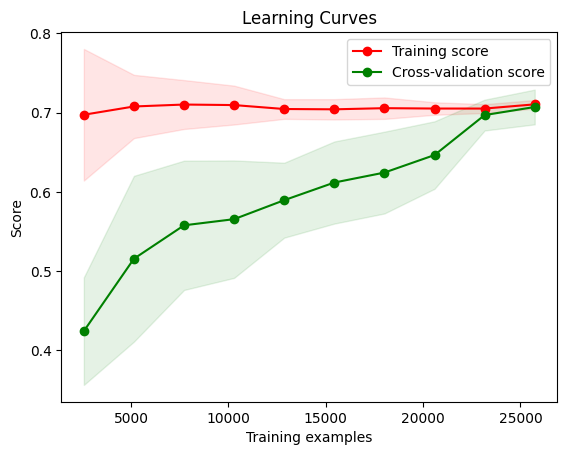

In [13]:
from sklearn.model_selection import learning_curve

def plot_learning_curves(model, X_train, y_train, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=cv, n_jobs=-1, 
        train_sizes=np.linspace(.1, 1.0, 10),
        scoring='accuracy'
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title("Learning Curves")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")

    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


model = svm_classifier
plot_learning_curves(model, x_train, y_train, cv=5)
plt.show()

# 5. Model Evaluation

In [18]:
# evaluate with test set
y_pred = logreg_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


0.879
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       581
           1       0.90      0.90      0.90       695
           2       0.70      0.80      0.74       159
           3       0.88      0.85      0.87       275
           4       0.89      0.82      0.85       224
           5       0.69      0.73      0.71        66

    accuracy                           0.88      2000
   macro avg       0.83      0.84      0.83      2000
weighted avg       0.88      0.88      0.88      2000

[[539  13   5  15   6   3]
 [  4 626  47   6   4   8]
 [  4  25 127   2   1   0]
 [ 19  12   2 235   7   0]
 [ 11  10   1   8 183  11]
 [  4   8   0   2   4  48]]


In [19]:
y_pred = mnb_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


0.853
              precision    recall  f1-score   support

           0       0.86      0.93      0.90       581
           1       0.86      0.91      0.88       695
           2       0.74      0.65      0.69       159
           3       0.88      0.77      0.82       275
           4       0.89      0.79      0.83       224
           5       0.76      0.59      0.67        66

    accuracy                           0.85      2000
   macro avg       0.83      0.77      0.80      2000
weighted avg       0.85      0.85      0.85      2000

[[542  15   1  13   9   1]
 [ 15 633  35   3   4   5]
 [ 11  40 104   4   0   0]
 [ 29  29   1 211   5   0]
 [ 23  11   0   7 177   6]
 [  9  12   0   1   5  39]]


In [21]:
y_pred = svm_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


0.8535
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       581
           1       0.87      0.92      0.89       695
           2       0.69      0.74      0.71       159
           3       0.86      0.77      0.81       275
           4       0.85      0.75      0.80       224
           5       0.64      0.64      0.64        66

    accuracy                           0.85      2000
   macro avg       0.80      0.79      0.79      2000
weighted avg       0.85      0.85      0.85      2000

[[530  27   3  12   7   2]
 [  3 637  39   4   3   9]
 [  8  29 117   4   1   0]
 [ 26  19   4 213  12   1]
 [ 14  10   6  14 168  12]
 [  4  11   1   2   6  42]]


#6. Generative Models

In [ ]:
#create generative model

